In [1]:
import ROOT as r
import matplotlib.pyplot as plt
import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting import Hist, HistStack, Legend, Canvas
from rootpy.io import root_open
import rootpy
import numpy as np
import matplotlib.pylab as pylab
from sklearn import metrics
import root_numpy
from scipy.interpolate import interp1d

params = {'legend.fontsize': 'x-large', 'axes.labelsize': 'x-large', 'axes.titlesize':'x-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

output_folder = "/afs/cern.ch/user/c/chreisse/BTagAnalyzer/output/Oct25/"

Welcome to JupyROOT 6.14/09


DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
file_list = [
    output_folder + "ttbar_puppi_2021.root",
    output_folder + "ttbar_puppi_2023.root",
    output_folder + "ttbar_puppi_2024.root",
    output_folder + "TTjets_puppi_2018.root"
]

def load_data(file_list):
    
    data = {}
    
    for f in file_list:
        
        print("data loaded for file {0}".format(f))
        
        rootfile = r.TFile.Open(f)
        tree = rootfile.Get("tree")
        
        data[f] = root_numpy.tree2array(tree)
        
    return data

df = load_data(file_list)

data loaded for file /afs/cern.ch/user/c/chreisse/BTagAnalyzer/output/Oct25/ttbar_puppi_2021.root
data loaded for file /afs/cern.ch/user/c/chreisse/BTagAnalyzer/output/Oct25/ttbar_puppi_2023.root
data loaded for file /afs/cern.ch/user/c/chreisse/BTagAnalyzer/output/Oct25/ttbar_puppi_2024.root
data loaded for file /afs/cern.ch/user/c/chreisse/BTagAnalyzer/output/Oct25/TTjets_puppi_2018.root


# Plot simple distributions

In [3]:
def plot(f, df, v, PU):

    data = df[f]

    if PU != None:
        selc = ((data["nPUtrue"] >= PU[0]) & (data["nPUtrue"] < PU[1]))
    else:
        selc = np.ones(data["nPUtrue"].shape, dtype=bool)
    
    b = data[v][(data["Jet_hadronFlavour"] ==5)  & selc]
    c = data[v][(data["Jet_hadronFlavour"] ==4)  & selc]
    l = data[v][(data["Jet_hadronFlavour"] ==0)  & selc]

    # normalize histograms
    weights_b = np.ones(b.shape)/float(b.shape[0])
    weights_c = np.ones(c.shape)/float(c.shape[0])
    weights_l = np.ones(l.shape)/float(l.shape[0])
    
    fig = plt.figure()
    plt.hist(b, 50, histtype="step", weights=weights_b)
    plt.hist(c, 50, histtype="step", weights=weights_c)
    plt.hist(l, 50, histtype="step", weights=weights_l)
    plt.xlabel(v)
    plt.ylabel("A.U.")

In [4]:
def plot_event_variables(files, df, v, PU):
    
    fig = plt.figure()
    bins = np.arange(0, 80, 1.0).tolist()
    
    for f in files:
        rootfile = r.TFile.Open(f)
        tree = rootfile.Get("tree")
    
        data = df[f]

        if PU != None:
            selc = ((data["nPUtrue"] >= PU[0]) & (data["nPUtrue"] < PU[1]))
        else:
            selc = np.ones(data["nPUtrue"].shape, dtype=bool)
    
        data = data[v][selc]
        weights = np.ones(data.shape)/float(data.shape[0])
        label = f[-9:-5]
        plt.hist(data, bins, histtype="step", weights=weights, label = f[-9:-5])
        
        
    plt.title(r"$\mathbf{CMS}$ private work", fontsize=16, x=0.0, ha="left", y=1.05, va="top")    
    plt.xlabel(v)
    plt.ylabel("A.U.")
    plt.xlim([0,80])
    plt.ylim([0,0.1])
    plt.legend()
    

DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.4 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:matplotlib.fon

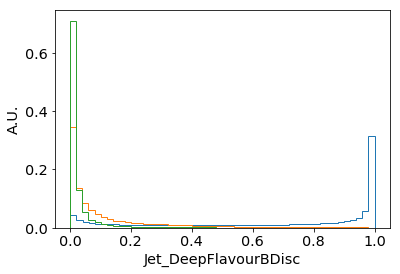

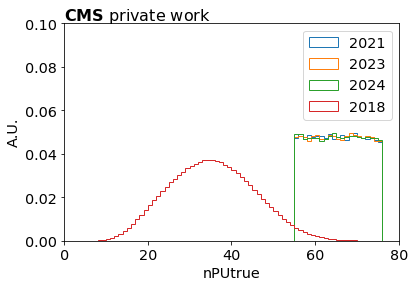

In [6]:
plot("/afs/cern.ch/user/c/chreisse/BTagAnalyzer/output/Oct25/ttbar_puppi_2021.root", df, "Jet_DeepFlavourBDisc", None)


plot_event_variables(file_list, df, "nPUtrue", None)

# Plot ROC curves

In [7]:
def roc(f, df, v, PU):
    
    data = df[f]
    
    fpr = {}
    tpr = {}
    eff = {}
    unc = {}

    
    if PU != None:
        selc = ((data["nPUtrue"] >= PU[0]) & (data["nPUtrue"] < PU[1]))
    else:
        selc = np.ones(data["nPUtrue"].shape, dtype=bool)

    BvsL_pred = data[v][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==0)) & selc ]
    BvsC_pred = data[v][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==4)) & selc ]
    BvsL_true = data["Jet_hadronFlavour"][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==0)) & selc]
    BvsC_true = data["Jet_hadronFlavour"][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==4)) & selc]
    
    fpr["BvsL"], tpr["BvsL"], thresholds = metrics.roc_curve(BvsL_true, BvsL_pred,pos_label=5.)
    fpr["BvsC"], tpr["BvsC"], thresholds = metrics.roc_curve(BvsC_true, BvsC_pred,pos_label=5.)
    
    for d in ["BvsL", "BvsC"]:
        func = interp1d(fpr[d], tpr[d], kind="linear")
        eff[d] = float(func(0.1))

    # uncertainty on efficiency
    unc["BvsL"] = np.sqrt(eff["BvsL"] * (1-eff["BvsL"]) / float(BvsL_pred.shape[0]))
    unc["BvsC"] = np.sqrt(eff["BvsC"] * (1-eff["BvsC"]) / float(BvsC_pred.shape[0]))
        
    p1 = plt.plot(tpr["BvsL"], fpr["BvsL"], label= "PU: {0}".format(PU))
    p2 = plt.plot(tpr["BvsC"], fpr["BvsC"], ls="--", color=p1[0].get_color())
    
    return eff["BvsL"], eff["BvsC"], unc["BvsL"], unc["BvsC"]


In [8]:
def plot_several_roc(filelist, df, v, puBinning, label):
    
    eff_L = []
    eff_C = []
    unc_L = []
    unc_C = []
    
    fig = plt.figure()
    plt.xlim([0.0,1.0])
    plt.ylim([0.0005, 1.0])
    plt.yscale("log")
    plt.grid(axis='both', which='both')
    plt.xlabel("b efficiency")
    plt.ylabel("mistag rate")
    plt.title(r"$\mathbf{CMS}$ private work", fontsize=16, x=0.0, ha="left", y=1.05, va="top")
    plt.text(0.99, 0.99, label, fontsize=12, ha="right", va="bottom")
    
    for f in filelist:
        for puBin in puBinning:
            res = roc(f, df, v, puBin)
            eff_L.append(res[0])
            eff_C.append(res[1])
            unc_L.append(res[2])
            unc_C.append(res[3])
    plt.legend()
    plt.show()
    return eff_L, eff_C, unc_L, unc_C

DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


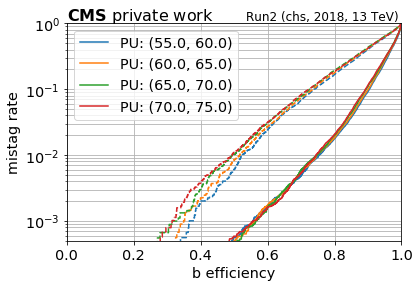

([0.9037910037320762,
  0.9006666406767767,
  0.8940110276865322,
  0.8922165152113789],
 [0.7390689451974072,
  0.7352150013644693,
  0.726341310808697,
  0.7233504543658633],
 [0.0011593732435680121,
  0.0011732655212149722,
  0.0012063535200881536,
  0.001221243014753709],
 [0.0023675594470278873,
  0.002373412823833303,
  0.0023965167484672613,
  0.0024206814792299557])

In [9]:
plot_several_roc([file_list[1]], df, "Jet_DeepFlavourBDisc", [(55.,60.), (60.,65.), (65.,70.), (70., 75.)], label="Run2 (chs, 2018, 13 TeV)")

In [10]:
def plot_efficiency(eff_list, unc_list, PU_list, label, cap):
    
    fig = plt.figure(figsize=(6,4))
    plt.xlim([0,80])
    plt.title(r"$\mathbf{CMS}$ private work", fontsize=16, x=0.0, ha="left", y=1.05, va="top")
    #plt.text(0.99, 0.99, cap, fontsize=12, ha="right", va="top")
    for ieff, eff in enumerate(eff_list):
        unc = unc_list[ieff]
        unc_up = [sum(x) for x in zip(eff, unc)]
        unc_down = [x - y for x,y in zip(eff, unc)]
        p = plt.plot(PU_list[ieff], eff+[eff[-1]], drawstyle="steps-post", label=label[ieff])
        #plt.plot(PU_list[ieff], unc_up+[unc_up[-1]], drawstyle="steps-post", c= p[0].get_color(), ls=":")
        #plt.plot(PU_list[ieff], unc_down+[unc_down[-1]], drawstyle="steps-post", c=p[0].get_color(), ls=":")
        plt.fill_between(PU_list[ieff], unc_down+[unc_down[-1]], unc_up+[unc_up[-1]], step='post', color=p[0].get_color(), alpha=0.25)
    
    plt.legend()
    plt.xlabel("nPUtrue")
    plt.ylabel("b efficiency (mistag rate: 1%)")
    plt.show()

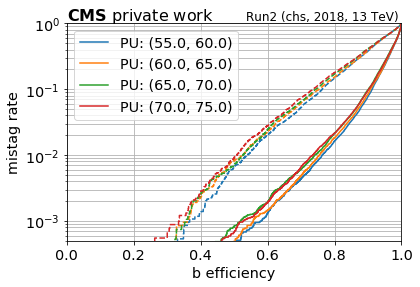

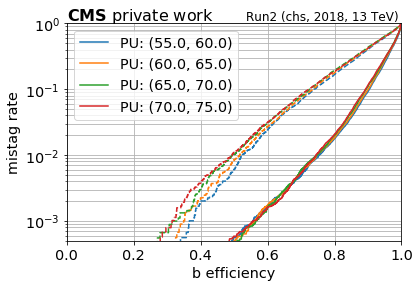

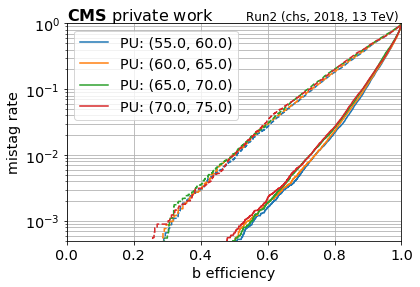

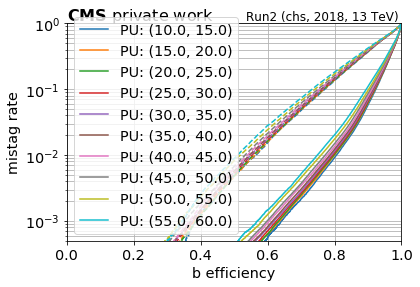

[[0.0010828835991302497, 0.0011132208188396459, 0.0011436240816903446, 0.0011472245223491323], [0.0011593732435680121, 0.0011732655212149722, 0.0012063535200881536, 0.001221243014753709], [0.001204271083738715, 0.0012271738685852645, 0.0012492493315042754, 0.0012572498917205685], [0.00038894664590284476, 0.00019516355596819, 0.00013612640913804764, 0.00011330603472686734, 0.00010492232401691333, 0.00010652452825070445, 0.00011939216065548753, 0.00014994228267027046, 0.00021231559035916526, 0.0003460497438579485]]


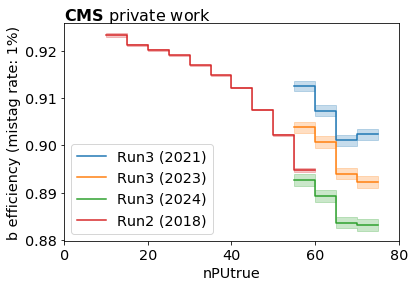

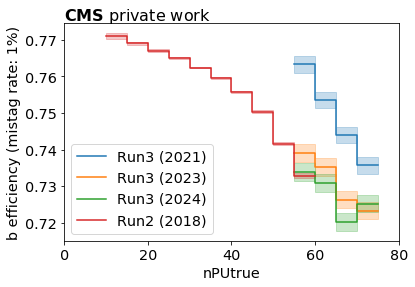

In [11]:
l = []

l += plot_several_roc([file_list[0]], df, "Jet_DeepFlavourBDisc", [(55.,60.), (60.,65.), (65.,70.), (70., 75.)], label="Run2 (chs, 2018, 13 TeV)")
l += plot_several_roc([file_list[1]], df, "Jet_DeepFlavourBDisc", [(55.,60.), (60.,65.), (65.,70.), (70., 75.)], label="Run2 (chs, 2018, 13 TeV)")
l += plot_several_roc([file_list[2]], df, "Jet_DeepFlavourBDisc", [(55.,60.), (60.,65.), (65.,70.), (70., 75.)], label="Run2 (chs, 2018, 13 TeV)")
l += plot_several_roc([file_list[3]], df, "Jet_DeepFlavourBDisc", [(10.,15.), (15.,20.), (20.,25.), (25., 30.), (30., 35.), (35.,40.), (40., 45.), (45.,50.), (50.,55.), (55., 60.)], label="Run2 (chs, 2018, 13 TeV)")


eff_L = l[0::4]
eff_C = l[1::4]
unc_L = l[2::4]
unc_C = l[3::4]

PU = [
    [55.,60.,65.,70., 75.],
    [55.,60.,65.,70., 75.],
    [55.,60.,65.,70., 75.],
    [10.,15.,20.,25.,30.,35.,40.,45.,50.,55.,60.]
]

print(unc_L)

plot_efficiency(eff_L, unc_L, PU, ["Run3 (2021)", "Run3 (2023)", "Run3 (2024)", "Run2 (2018)"], "chs (BvsL)")
plot_efficiency(eff_C, unc_C, PU, ["Run3 (2021)", "Run3 (2023)", "Run3 (2024)", "Run2 (2018)"], "chs (BvsC)")